# Importing necessary dependancies

In [228]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, LdaMulticore,CoherenceModel

#spacy for lemmatization
import spacy

#nltk
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

#Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [229]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [230]:
#For writting in excel file


from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows

# Create new workbook
wb = Workbook()
wb.save('D:\ML_handson\TopicModeling.xlsx')

# Load existing workbook
book = load_workbook('D:\ML_handson\TopicModeling.xlsx')

writer = pd.ExcelWriter('TopicModeling.xlsx', engine='openpyxl') 
writer.book = book

## ExcelWriter for some reason uses writer.sheets to access the sheet.
## If you leave it empty it will not know that sheet Main is already there
## and will create a new sheet.

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

writer.save()

# Scraping for Data retrieval

In [231]:
#list of urls from where we want to extract the data
seed_urls=['https://inshorts.com/en/read/technology',
          'https://inshorts.com/en/read/sports',
          'https://inshorts.com/en/read/politics']

def build_dataset(seed_urls):
  news_data=[]
  for url in seed_urls:
    news_category=url.split('/')[-1]#Split by '/' character and last string from array
    data=requests.get(url)
    soup=BeautifulSoup(data.content,'html.parser')#Returns BeautifulSoup object
    #print(soup)
    #Extract the news headline,article text and category
    news_articles = [{'news_headline': headline.find('span', 
                                                          attrs={"itemprop": "headline"}).string,
                            'news_article': article.find('div', 
                                                        attrs={"itemprop": "articleBody"}).string,
                            'news_category': news_category}
                          
                              for headline, article in 
                              zip(soup.find_all('div', 
                                                class_=["news-card-title news-right-box"]),
                                  soup.find_all('div', 
                                                class_=["news-card-content news-right-box"]))]
    #print(news_articles)
    news_data.extend(news_articles)
    df=pd.DataFrame(news_data)
    df=df[['news_headline','news_article','news_category']]
  return df

In [232]:
news_df=build_dataset(seed_urls)

news_df.to_excel(writer, sheet_name='News article',index=False,startrow=0,startcol=0)
 
writer.save()
#news_df.to_excel(r'D:\ML_handson\TopicModeling.xlsx', sheet_name='NewsArticle', index = False)
news_df.head(5)

,news_headline,news_article,news_category
0,"OnePlus 8, OnePlus 8 Pro India prices announced; starts at ₹41,999","OnePlus has announced the India pricing for its latest flagship offering, OnePlus 8 series. The OnePlus 8 gets a starting price of ₹41,999 with 6GB RAM+128GB storage, whereas OnePlus 8 Pro will re...",technology
1,2 men step out amid lockdown and make TikTok video demeaning police; both held,Police in Maharashtra's Dongri arrested two men aged 24 and 19 for allegedly stepping out of their houses and recording a TikTok video. They were also paraded in Bhendi Bazaar area as the two were...,technology
2,Microsoft launching chatbot to urge recovered patients to donate plasma,"Microsoft, working with a consortium of US-based pharmaceutical firms, will launch a chatbot to encourage recovered COVID-19 patients to donate plasma. The ""Plasmabot"" will help people determine w...",technology
3,Facebook's COVID-19 survey to be available to users worldwide,"Facebook's COVID-19 survey will be available to users worldwide to help researchers predict the spread of the disease. Users will see a link at top of News Feed for the survey, insights from which...",technology
4,Smartphone sales through e-commerce to remain suspended until May 3,"The sale of smartphones, laptops and PCs, considered non-essential goods, will remain suspended through e-commerce channels like Amazon, Flipkart and others until May 3. This comes as the governme...",technology


In [233]:
news_df.news_category.value_counts()

technology    25
sports        25
politics      25
Name: news_category, dtype: int64

# Text Pre-processing

In [234]:
#Convert to List
data=news_df.news_article.values.tolist()
print(data[:1])


['OnePlus has announced the India pricing for its latest flagship offering, OnePlus 8 series. The OnePlus 8 gets a starting price of ₹41,999 with 6GB RAM+128GB storage, whereas OnePlus 8 Pro will retail at ₹54,999 with 8GB of RAM+128GB storage. The OnePlus 8  smartphone comes with 48 MP Triple Camera while OnePlus 8 Pro comes with 48 MP Quad Camera.']


In [235]:
## Tokenizing words and cleanup text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))#deacc=True removes punctuation
        
data_words=list(sent_to_words(data))
print(data_words[:1])

[['oneplus', 'has', 'announced', 'the', 'india', 'pricing', 'for', 'its', 'latest', 'flagship', 'offering', 'oneplus', 'series', 'the', 'oneplus', 'gets', 'starting', 'price', 'of', 'with', 'gb', 'ram', 'gb', 'storage', 'whereas', 'oneplus', 'pro', 'will', 'retail', 'at', 'with', 'gb', 'of', 'ram', 'gb', 'storage', 'the', 'oneplus', 'smartphone', 'comes', 'with', 'mp', 'triple', 'camera', 'while', 'oneplus', 'pro', 'comes', 'with', 'mp', 'quad', 'camera']]


#### Creating Bigram and Trigram Models

Bigrams are two words frequently occuring together in the document .Trigrams are 3 words frequently occuring

Gensim's `Phrases` model can build and implement the bigrams, trigrams and quadgrams and more.

In [236]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['oneplus', 'has', 'announced', 'the', 'india', 'pricing', 'for', 'its', 'latest', 'flagship', 'offering', 'oneplus', 'series', 'the', 'oneplus', 'gets', 'starting', 'price', 'of', 'with', 'gb', 'ram', 'gb', 'storage', 'whereas', 'oneplus', 'pro', 'will', 'retail', 'at', 'with', 'gb', 'of', 'ram', 'gb', 'storage', 'the', 'oneplus', 'smartphone', 'comes', 'with', 'mp', 'triple', 'camera', 'while', 'oneplus', 'pro', 'comes', 'with', 'mp', 'quad', 'camera']


In [237]:
#define functions for stopwords, bigrams,trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's invoke the functions in order 

In [238]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[23])

['refuse', 'pay', 'ex', 'engineer', 'legal', 'award', 'owe', 'plead', 'guilty', 'trade', 'secret', 'theft', 'recruit', 'investigation', 'reveal', 'transfer', 'confidential', 'file', 'know', 'never', 'would', 'enter', 'agreement', 'say']


### Create the dictionary and corpus needed for topic modeling

In [239]:
#create dictionary
id2word=corpora.Dictionary(data_lemmatized)

'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
#id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

#Create corpus
texts=data_lemmatized

#Term Document Frequency(BagOfWords)

corpus=[id2word.doc2bow(text) for text in texts]

#view
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

In [240]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('announce', 1),
  ('camera', 1),
  ('come', 2),
  ('flagship', 1),
  ('get', 1),
  ('late', 1),
  ('offer', 1),
  ('oneplus', 4),
  ('price', 2),
  ('pro', 1),
  ('series', 1),
  ('smartphone', 1),
  ('start', 1),
  ('storage', 2),
  ('triple', 1)]]

### Building  the Topic Model

**We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some parameters for tweaking are:

- num_topics : Number of latent topics to be extracted
- id2word : mapping from word ids(integer) to words(strings).Used to determine vocabulary size
- workers : Number of extra processes to use for parallelization
- alpha and eta : hyperparameters that affect the sparsity of the document-topic(theta) and topic-word(lambda) ditributions.Default values are 1.0/num_topics
    - Alpha is per document topic distribution
        - High alpha : Every document has a mixture of all topics ( documents appear similar to each other)
        - Low alpha : Every document has a mixture of very few topics.
        
    - Eta is per topic word distribution
        - High eta : Each topic has a mixture of most words (topics appear similar to each other)
        - Low eta : Each topic has a mixture of few words.
        
- Passes : number of training passes through the corpus

In [241]:
#Let's build a LDA topic model with 3 topics (As per news divided originally in 3 categpries), using LdaMulticore().
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           )

### View the topics in LDA model
The above model is built with 3 different topics where each topic is a combination of keywords and each keyword contributes a certain weightages to the topic.

In [242]:
print(lda_model.print_topics())
doc_lda=lda_model[corpus]

[(0, '0.028*"say" + 0.013*"government" + 0.010*"add" + 0.009*"state" + 0.008*"lockdown" + 0.008*"make" + 0.007*"ask" + 0.006*"people" + 0.006*"use" + 0.005*"test"'), (1, '0.023*"say" + 0.012*"add" + 0.011*"former" + 0.008*"government" + 0.007*"lead" + 0.006*"lockdown" + 0.006*"address" + 0.006*"team" + 0.006*"website" + 0.006*"also"'), (2, '0.024*"say" + 0.009*"add" + 0.009*"state" + 0.008*"government" + 0.008*"also" + 0.007*"people" + 0.007*"help" + 0.006*"play" + 0.005*"call" + 0.005*"use"')]


#### How to interpret this ?
- Topic 0 is a represented as 
'0.016*"say" + 0.011*"government" + 0.010*"also" + 0.010*"add" + 0.009*"video" + 0.008*"come" + 0.008*"call" + 0.006*"make" + 0.006*"ensure" + 0.006*"hold"

- Topic 1 is a represented as 
'0.033*"say" + 0.016*"government" + 0.013*"add" + 0.012*"state" + 0.010*"people" + 0.007*"lockdown" + 0.005*"covid" + 0.005*"tweet" + 0.005*"new" + 0.005*"take"

- Topic 2 is a represented as 
'0.028*"say" + 0.011*"former" + 0.008*"add" + 0.008*"use" + 0.008*"test" + 0.006*"state" + 0.006*"see" + 0.005*"football" + 0.005*"also" + 0.005*"good"

The weights reflect how important a keyword is to that topic.

### Original Classification of the topics

1. Technolgy
2. Sports
3. Politics

### Compute Model Perplexity and coherence Score

Model Perplexity and topic coherence provide q onvinient measure to evaluate how good a given topic model is.

In [243]:
#compute perplexity
print('\nPerplexity : ',lda_model.log_perplexity(corpus))#Lower the better

#ComputeCoherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\n Coherence Score : ',coherence_lda)



Perplexity :  -6.833544523677246

 Coherence Score :  0.4260537809637304


### Visualize the topics- keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. 

In [244]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054640  0.073930       1        1  40.893005
2     -0.037893 -0.083423       2        1  31.190470
1      0.092533  0.009493       3        1  27.916523, topic_info=              Term      Freq      Total Category  logprob  loglift
388           lead  3.000000   3.000000  Default  30.0000  30.0000
444         former  9.000000   9.000000  Default  29.0000  29.0000
671        address  3.000000   3.000000  Default  28.0000  28.0000
546       football  3.000000   3.000000  Default  27.0000  27.0000
25            help  6.000000   6.000000  Default  26.0000  26.0000
..             ...       ...        ...      ...      ...      ...
602      criticise  1.484858   2.575358   Topic3  -5.8075   0.7253
791  strategically  1.471265   3.343884   Topic3  -5.8167   0.4549
50            firm  1.470867   4.592963   Topic3  -5.8169   0.1373
55          people  1.470026  10.105589   Topic3  -5.8175  -0.6519
420        twitter  1.470022   3.286210   Topic3  -5.8175   0.4715

[201 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
124       1  0.388739      add
124       2  0.277670      add
124       3  0.333204      add
671       3  0.942975  address
651       3  0.520052   allege
...     ...       ...      ...
256       2  0.376547    would
256       3  0.188273    would
143       1  0.250810     year
143       2  0.752431     year
448       2  1.015102   yuvraj

[243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### How to infer pyLDAvis output

Each bubble represents a topic.The larger it is, the more prevalent is that topic
A good topic model will have fairly big, non-overlapping bubbles scattered throughout
the chart instead of being clustered in one quadrant.

### Observation

What I've observed ism If k=3 (as all news are originally divided into 3 categories), There are few keywords ,which are responsible for categorizing text into 3 categories

- Topic 0 : say, add, government, people, state, also, lockdown, use, tweet, former
- Topic 1 : say, add, video, people, ask, lockdown, oneplus, number, fund, government
- Topic 2 : say, government, add, state, test, former, help, also, come, may

So here, we can see k=3 is not sufficient to judge the topic by its context.

### How to find the optimal number of topics for LDA?
Build many LDA models with different values of number of topics(k) and pick the one
that gives the highest coherence value

In [245]:
def compute_coherence_values(dictionary,corpus,texts,limit,start=2,step=3 ):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values=[]
    model_list=[]
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                        )
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model,texts=texts,dictionary=dictionary,coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list,coherence_values

In [246]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=40, step=5)

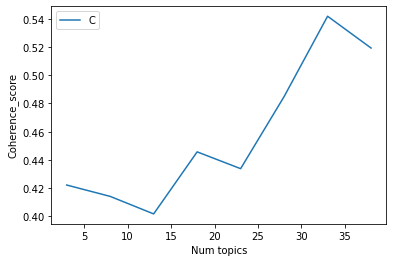

In [247]:
#show graph
limit=40;start=3;step=5;
x=range(start,limit,step)
plt.plot(x,coherence_values)
plt.xlabel('Num topics')
plt.ylabel('Coherence_score')
plt.legend(('Coherence values'),loc='best')
plt.show()

In [248]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4222
Num Topics = 8  has Coherence Value of 0.4141
Num Topics = 13  has Coherence Value of 0.4017
Num Topics = 18  has Coherence Value of 0.4457
Num Topics = 23  has Coherence Value of 0.4338
Num Topics = 28  has Coherence Value of 0.4849
Num Topics = 33  has Coherence Value of 0.5419
Num Topics = 38  has Coherence Value of 0.5193


If the coherence score seems to keep increasing, it's better to pick the model that gave the highest CV before flattening out.

So I'll choose the model with 33 topics.

In [253]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(32, '0.025*"government" + 0.024*"say" + 0.023*"make" + 0.017*"video" + 0.016*"covid" + 0.011*"directly" + 0.011*"hit" + 0.011*"responsible" + 0.011*"part" + 0.011*"could"'), (7, '0.039*"state" + 0.020*"say" + 0.019*"government" + 0.019*"order" + 0.016*"office" + 0.016*"people" + 0.014*"also" + 0.013*"pick" + 0.013*"grade" + 0.013*"ban"'), (19, '0.045*"say" + 0.029*"government" + 0.023*"run" + 0.022*"up" + 0.019*"test" + 0.017*"indian" + 0.017*"take" + 0.017*"corporate" + 0.016*"due" + 0.012*"team"'), (28, '0.046*"say" + 0.030*"government" + 0.012*"conduct" + 0.012*"crisis" + 0.012*"threat" + 0.012*"session" + 0.012*"necessary" + 0.012*"advance" + 0.012*"step" + 0.012*"add"'), (24, '0.034*"say" + 0.027*"state" + 0.016*"report" + 0.015*"score" + 0.015*"asymptomatic" + 0.014*"case" + 0.014*"add" + 0.014*"firm" + 0.013*"naked" + 0.013*"trainer"'), (16, '0.036*"say" + 0.030*"get" + 0.030*"field" + 0.022*"add" + 0.015*"coach" + 0.015*"great" + 0.015*"formative" + 0.015*"do" + 0.015*"hand" 

### Finding the dominant topic for each document

In [254]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
#df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.to_excel(writer, sheet_name='TopicperDoc_with38topics',index=False,startrow=0,startcol=0)
writer.save()
df_dominant_topic.head(5)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.9559,"oneplus, share, give, new, picture, cut, website, price, come, storage","OnePlus has announced the India pricing for its latest flagship offering, OnePlus 8 series. The OnePlus 8 gets a starting price of ₹41,999 with 6GB RAM+128GB storage, whereas OnePlus 8 Pro will re..."
1,1,32.0,0.9627,"government, say, make, video, covid, directly, hit, responsible, part, could",Police in Maharashtra's Dongri arrested two men aged 24 and 19 for allegedly stepping out of their houses and recording a TikTok video. They were also paraded in Bhendi Bazaar area as the two were...
2,2,10.0,0.9715,"patient, plasma, people, test, lead, dynamically, get, strategically, camera, donate","Microsoft, working with a consortium of US-based pharmaceutical firms, will launch a chatbot to encourage recovered COVID-19 patients to donate plasma. The ""Plasmabot"" will help people determine w..."
3,3,26.0,0.9654,"user, survey, use, scam, say, create, website, good, information, crisis","Facebook's COVID-19 survey will be available to users worldwide to help researchers predict the spread of the disease. Users will see a link at top of News Feed for the survey, insights from which..."
4,4,4.0,0.9641,"say, go, back, make, sale, chinese, respond, want, letter, government","The sale of smartphones, laptops and PCs, considered non-essential goods, will remain suspended through e-commerce channels like Amazon, Flipkart and others until May 3. This comes as the governme..."


### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [255]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf.to_excel(writer, sheet_name='TopicperContribution',index=False,startrow=0,startcol=0)
writer.save()
# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9654,"job, hold, government, allow, stadium, fan, face, belarus, talk, report","Congress on Friday urged central government to hold talks with US government to prevent job losses of Indians holding H-1B visas amid coronavirus pandemic. ""Time for PM (Narendra Modi) to ensure o..."
1,2.0,0.9578,"say, fund, fight, add, donate, social, adenoid, type, disease, positive",Rajasthan Chief Minister Ashok Gehlot on Saturday asked Prime Minister Narendra Modi to give the funds donated by the companies and industries in the state to the Rajasthan CM Relief Fund COVID-19...
2,3.0,0.9515,"test, government, case, asymptomatic, lead, add, resignation, say, report, decision",The Supreme Court on Monday held valid Madhya Pradesh Governor Lalji Tandon's decision to order a floor test after the resignation of 22 Congress MLAs. A floor test was necessary as the government...
3,4.0,0.9641,"say, go, back, make, sale, chinese, respond, want, letter, government","The sale of smartphones, laptops and PCs, considered non-essential goods, will remain suspended through e-commerce channels like Amazon, Flipkart and others until May 3. This comes as the governme..."
4,5.0,0.9612,"say, add, owaisi, yuvraj, use, thing, criticise, address, deprived, ignore","AIMIM chief Asaduddin Owaisi on Tuesday criticised PM Narendra Modi saying his addresses to the nation ""are things that can be done through a single tweet"". PM Modi has ""ignored plight of a vast m..."


### Topic distribution across documents

In [257]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_excel(writer, sheet_name='TopicDistribution',index=False,startrow=0,startcol=0)
writer.save()
writer.close()
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"oneplus, share, give, new, picture, cut, website, price, come, storage",2.0,0.0267
1.0,32.0,"government, say, make, video, covid, directly, hit, responsible, part, could",NaN,NaN
2.0,10.0,"patient, plasma, people, test, lead, dynamically, get, strategically, camera, donate",2.0,0.0267
3.0,26.0,"user, survey, use, scam, say, create, website, good, information, crisis",1.0,0.0133
4.0,4.0,"say, go, back, make, sale, chinese, respond, want, letter, government",7.0,0.0933
...,...,...,...,...
70.0,19.0,"say, government, run, up, test, indian, take, corporate, due, team",NaN,NaN
71.0,3.0,"test, government, case, asymptomatic, lead, add, resignation, say, report, decision",NaN,NaN
72.0,22.0,"fail, ensure, government, lockdown, follow, claim, issue, west, bengal, completely",NaN,NaN
73.0,28.0,"say, government, conduct, crisis, threat, session, necessary, advance, step, add",NaN,NaN


#### References : 

- https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb

- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

- https://www.machinelearningplus.com/nlp/gensim-tutorial/

- https://rare-technologies.com/what-is-topic-coherence/